#Laboratory work from the course HPC: Bilateral filtering on GPU.







# Introduction



##Task defeniton

Given the image of size M*N, implement and apply a CUDA version of 9-point bilateral filter and store the
result to output image.<br> Missing values for edge rows and columns are to be taken from nearest pixels.<br> CUDA
implementation must make use of texture memory.

##Proposed method

The following method could be used to implement the bilateral filter:
1. Copy input data to device memory;
2. Bind input data to a texture link;
3. Extract each pixel together with its surrounding pixels via texture memory into 9-elements array;
4. Calculate the result pixel intensity using the formulas above;
5. Store the result into the array.

##Implementation requirements

Input data <br>
  • Input grayscale image in BMP format, sigma values;<br>
Output data<br>
  • The time of image processing using GPU;<br>
  • The time of image processing using СPU;<br>
  • Resulting images in BMP format.<br>

# Solution

##Preparation for work

To work with the GPU, we need the pycuda library, which contains the necessary algorithms and methods. You can install this library with the following command:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pycuda

In [ ]:
!pip install py-cpuinfo

In [ ]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

In [ ]:
!nvidia-smi

Also, for work, we need the following libraries, we import them immediately.

In [6]:
from pycuda import driver, compiler, gpuarray
import pycuda.autoinit
import numpy as np
import cv2
import time
from google.colab.patches import cv2_imshow
from pycuda.compiler import SourceModule

##Description of functions

Here we describe a bilateral filter for the CPU.

In [7]:
def calculate_pixel(image, i, j, sigma_d, sigma_r):    
    s = 0
    c = 0    
    for k in range(i-1, i+2):
        for l in range(j-1, j+2):
            g_coef_depend = np.exp(-((k - i) ** 2 + (l - j) ** 2) / sigma_d ** 2)
            i1 = image[k, l]
            i2 = image[i, j]
            r_new_intesity = np.exp(-((i1 - i2)** 2) / sigma_r ** 2)
            c += g_coef_depend*r_new_intesity
            s += g_coef_depend*r_new_intesity*image[k, l]
    result = s / c
    return result

# create new image after manipulation
def calculate_bilateral_CPU(image, sigma_d, sigma_r):
    new_image = np.zeros(image.shape)
    width = image.shape[0]
    height = image.shape[1]
    for i in range(1, width-1):
        for j in range(1, height-1):
            new_image[i, j] = calculate_pixel(image, i, j, sigma_d, sigma_r)
    return new_image

Here we describe a bilateral filter for the GPU.

In [ ]:
calculate_bilateral_GPU = SourceModule("""
texture<unsigned int, 2, cudaReadModeElementType> tex;

__global__ void bil_gpu(unsigned int * __restrict__ d_result, const int M, const int N, const float sigma_d, const float sigma_r)
{
    const int i = threadIdx.x + blockDim.x * blockIdx.x;
    const int j = threadIdx.y + blockDim.y * blockIdx.y;


    if ((i<M)&&(j<N)) {
        float s = 0;
        float c = 0;
        for (int l = i-1; l <= i+1; l++){
            for (int k = j-1; k <= j+1; k++){
                float firstImg = tex2D(tex, k, l)/255;
                float secondImg = tex2D(tex, i, j)/255;
                float g = exp(-(pow(k - i, 2) + pow(l - j, 2)) / pow(sigma_d, 2));
                float r = exp(-pow((firstImg - secondImg)*255, 2) / pow(sigma_r, 2));
                c += g*r;
                s += g*r*tex2D(tex, k, l);
            }
        }
        d_result[i*N + j] = s / c;
    }


}
""")

#Experiments

##Original image

Оригинал


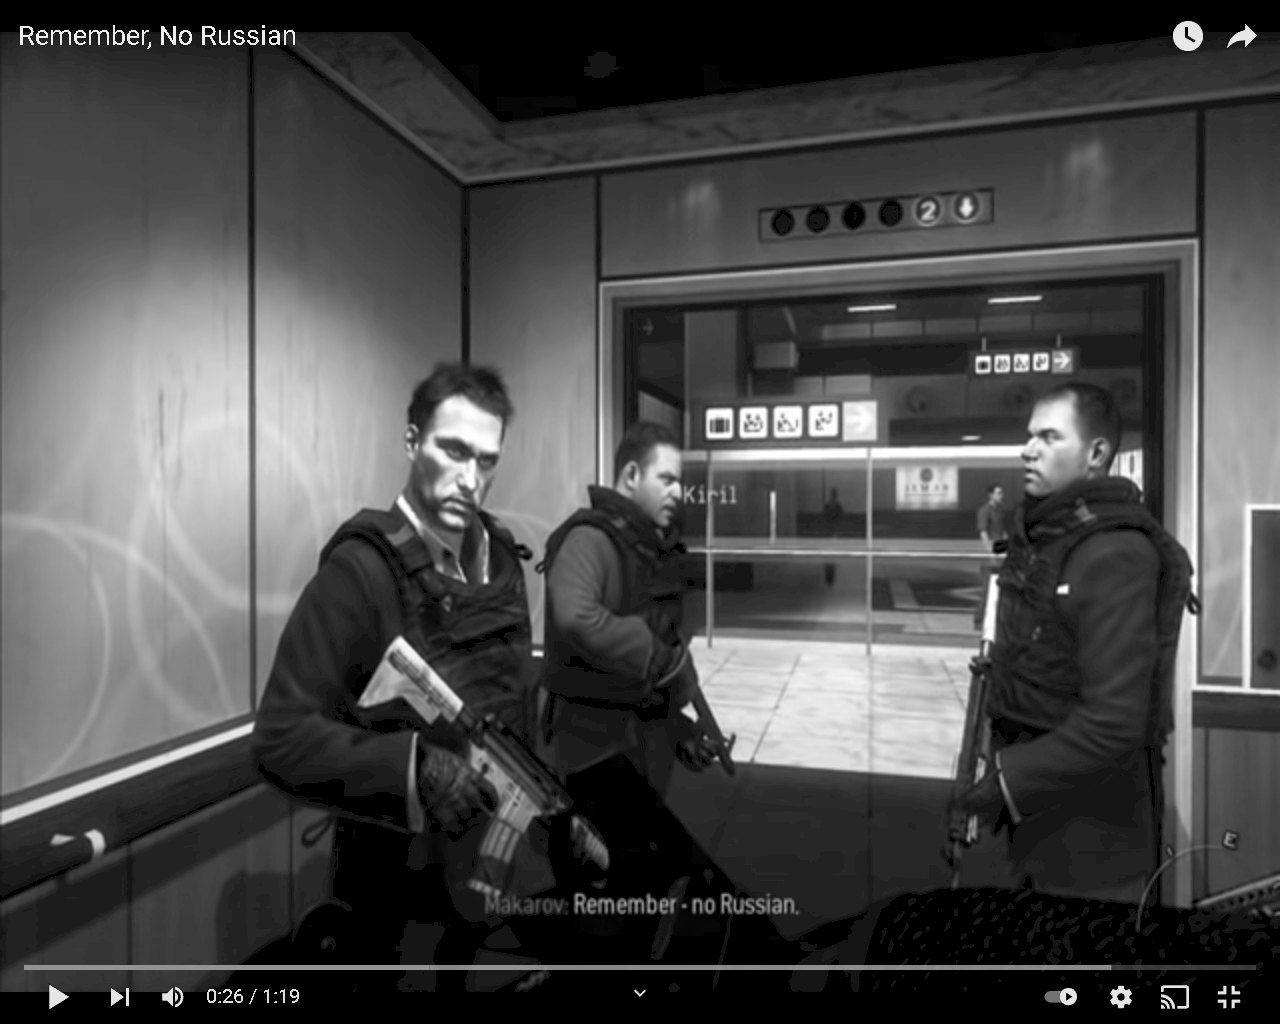

In [9]:
IMG = '/content/drive/MyDrive/HPC/price.jpg'
image = cv2.imread(IMG, cv2.IMREAD_GRAYSCALE)
cv2.imwrite('/content/drive/MyDrive/HPC/original.bmp', image)

print("Оригинал")
cv2_imshow(image)

In [10]:
sigma_d = 300
sigma_r = 300
M, N = image.shape

##Bilateral filtering on CPU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in ubyte_scalars
  if __name__ == '__main__':


Изображение CPU


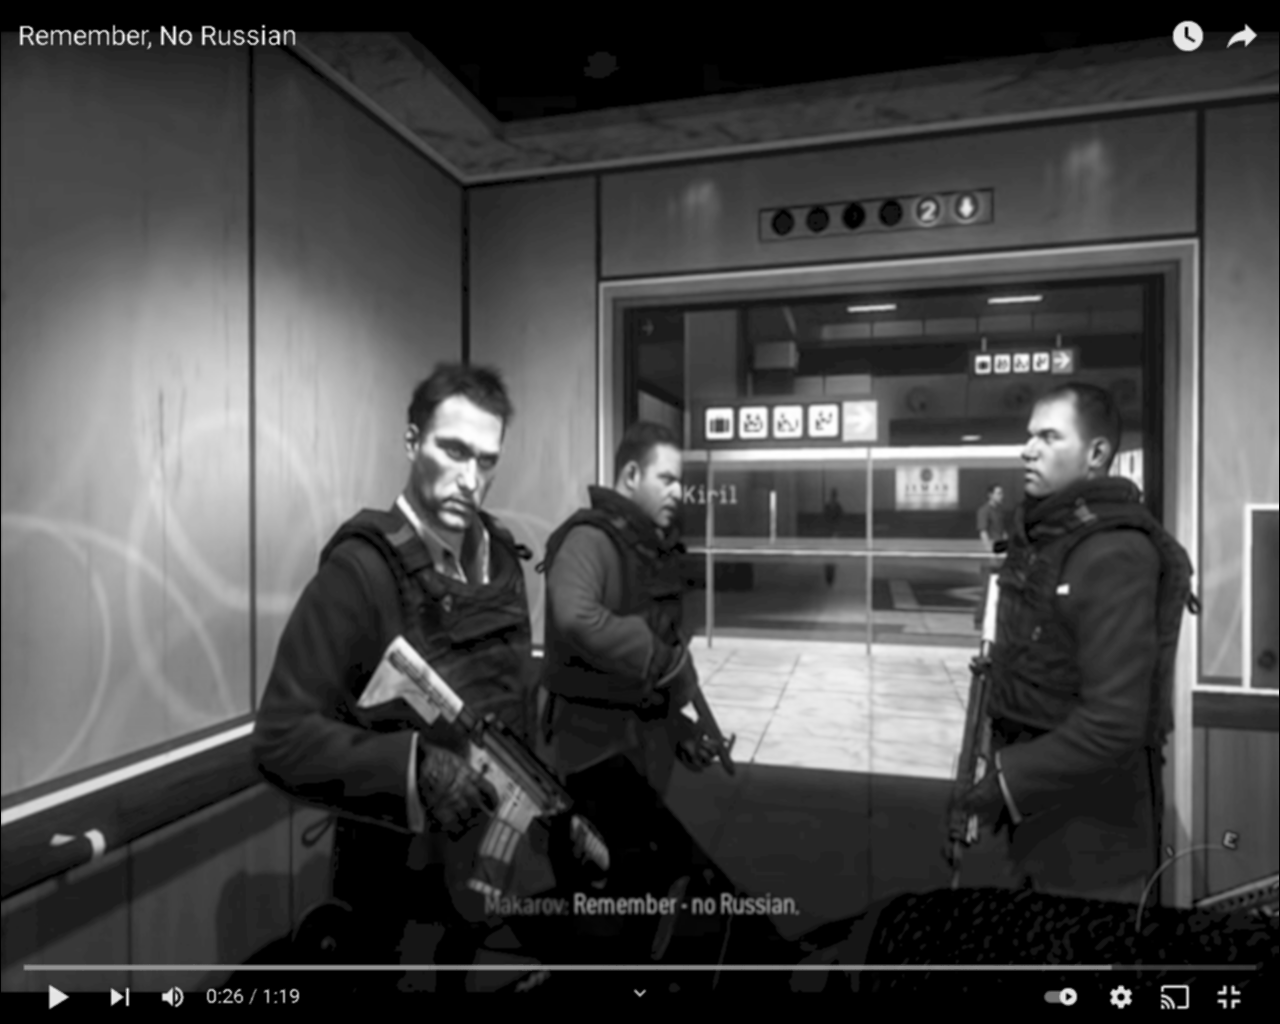

Время на CPU:  108.20402


In [11]:
cpu_start = time.time()
cpu_result = calculate_bilateral_CPU(image, sigma_d, sigma_r)
cpu_time = time.time() - cpu_start
cv2.imwrite('/content/drive/MyDrive/HPC/cpu_output.bmp', cpu_result)
print("Изображение CPU")
cv2_imshow(cpu_result)
print('Время на CPU: ', round(cpu_time,5))

##Bilateral filtering on GPU

Изображение GPU


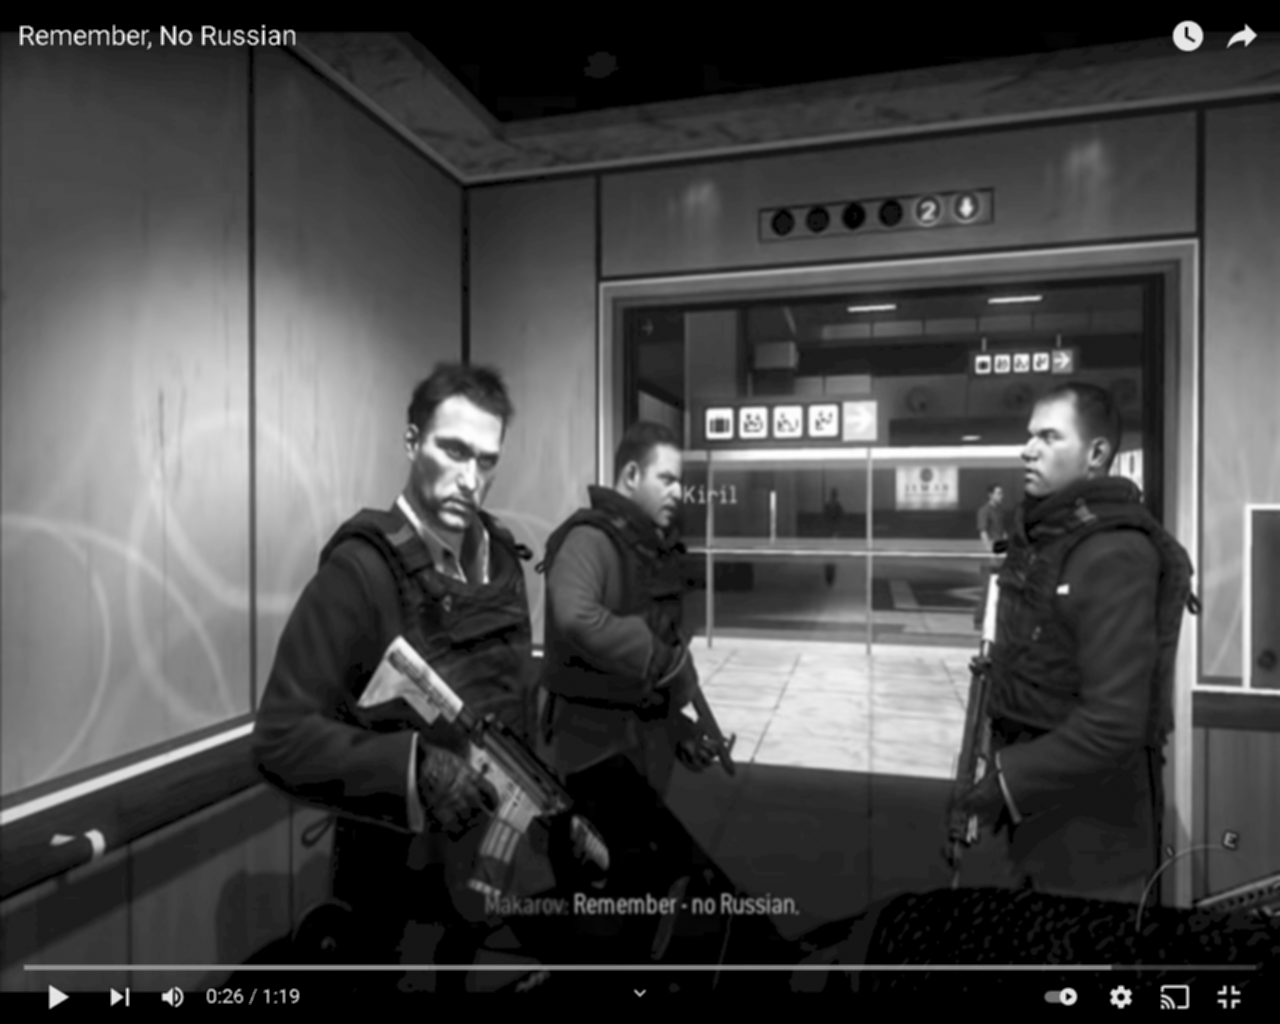

Время на GPU:  0.02473


In [12]:
gpu_result = np.zeros((M, N), dtype=np.uint32)
block = (32, 1, 1)
grid = (int(np.ceil(M/block[0])),int(np.ceil(N/block[1])))

bil_gpu = calculate_bilateral_GPU.get_function("bil_gpu")

gpu_start = time.time()

tex = calculate_bilateral_GPU.get_texref("tex")
tex.set_filter_mode(driver.filter_mode.LINEAR)
tex.set_address_mode(0, driver.address_mode.MIRROR)
tex.set_address_mode(1, driver.address_mode.MIRROR)
driver.matrix_to_texref(image.astype(np.uint32), tex, order="C")

bil_gpu(driver.Out(gpu_result), np.int32(M), np.int32(N), np.float32(sigma_d), np.float32(sigma_r), block=block, grid=grid, texrefs=[tex])

gpu_time = time.time() - gpu_start
print("Изображение GPU")
cv2.imwrite('/content/drive/MyDrive/HPC/gpu_output.bmp', gpu_result.astype(np.uint8))
cv2_imshow(gpu_result)
print('Время на GPU: ', round(gpu_time,5))

#Result

To summarize, we calculate the acceleration of the algorithm by finding the ratio of the time of the algorithm on the CPU to the time of the algorithm on the GPU.

In [13]:
print("Ускорение: ",cpu_time/gpu_time)

Ускорение:  4375.547800852278


As a result, we see a significant acceleration of the GPU relative to the CPU.